In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

import jax.numpy as jnp
import jax.random as random
import jax
from jax import jit,vmap,grad
key = random.PRNGKey(42)

N = 1  # single qubit
N1 = 10  # parameter space size

sz = jnp.array([[1, 0], [0, -1]], dtype=jnp.float32)

sx = jnp.array([[0, 1], [1, 0]], dtype=jnp.float32)

Now that we have the ideal result under master frequency $\omega$. With a change of frequency $\delta \omega$, the hyperparameter will change accordingly $\delta \vec{p}$

The first method is to use *Hessian* matrix to get a minimal hyperparameter set and do the black box optimization.

In [2]:
from Black_box_opt import GateOptimize, Hessian_eigen
from scipy.optimize import minimize
omega0 = 1.
p = random.normal(key, shape=(N1,))
t0 = 1.
gate_loss, p_final = GateOptimize(
    sx, omega0, t0, p, num_step=300, learning_rate=1.2)

_ ,vector_mat = Hessian_eigen(p_final)

# Now try different optimization method
dw = 0.03

# print(vector_mat)

t1_final = p_final[0]
p0_final = p_final[1]


print('starting optimize')

res_vec = minimize(loss_vec,jnp.zeros(3,dtype=jnp.float32),
    args=(vector_mat,t1_final,p0_final,omega0+dw,sx),method='Nelder-Mead',options={'return_all':True})

final loss =  0.0160533914173018670186757


RuntimeError: Invalid argument: Cannot bitcast types with different bit-widths: F64 => S32.
	, for instruction %bitcast-convert.10 = s32[] bitcast-convert(f64[] %real.9), metadata={op_type="bitcast_convert_type" op_name="bitcast_convert_type[ new_dtype=int64 ]" source_file="/Users/jeffreyyao/Documents/GitHub/qoptimize/Black_box_opt.py" source_line=40}

Or even better, we represent $A(\omega,t)$ as a simple neural network with ReLU activation.

In [53]:
from jax.nn import relu
@jit
def A(w,t,p):
    '''
    Single layer representation of control pulse
    '''
    
    def unpackp(p):
        #        w1                      b1              w2                                      b2
        return p[0:2*N1].reshape(N1,2), p[2*N1:3*N1].reshape(N1,), p[3*N1:4*N1].reshape(N1,), p[-1]
    
    w1, b1, w2, b2 = unpackp(p)
    
    x = jnp.array([w,t])
    
    return w2.T@(relu(w1@x+b1))+b2

In [54]:
p0 = random.normal(key,shape=(N1*4+1,))
A(omega0,t0,p0)

DeviceArray(-1.47835046, dtype=float64)

Try plot to see if it's continuous

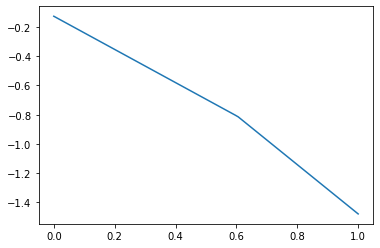

In [71]:
tlist = jnp.linspace(0,t0,100)
Alist = vmap(A,(None,0,None),0)(omega0,tlist,p0)
plt.plot(tlist,Alist)

In [72]:
from jax.experimental import ode, optimizers
from jax.experimental.ode import odeint

@jit
def loss(t1,flat_p, omega, U_T):
    '''
    define the loss function, which is a pure function
    '''
    t_set = jnp.linspace(0., t1, 5)

    D, _, = jnp.shape(U_T)
    U_0 = jnp.eye(D,dtype=jnp.complex128)

    def func(y, t, *args):
        omega, flat_p, = args

        return -1.0j*( omega* sz + A(omega,t,flat_p) * sx )@y
        # return -1.0j*( omega* sz)@y

    res = odeint(func, U_0, t_set, omega, flat_p, rtol=1.4e-10, atol=1.4e-10)
    
    U_F = res[-1, :,:]
    return (1 - jnp.abs(jnp.trace(U_T.conj().T@U_F)/D)**2)

lossvmap = jit(vmap(loss,(None,None,0,None),0))

In [75]:
def GateOptimizeOmega(U_F, omega, t1, init_param, num_step=300, learning_rate=1.0):
    '''
    Get the best possible parameter
    psi_i: initial wave function
    psi_f: final wave function
    init_param: initial parameters
    '''
    opt_init, opt_update, get_params = optimizers.adam(
        learning_rate)  # Use adam optimizer
    loss_list = []

    def unpack(x):
                # t , args
        return x[0], x[1:]

    def step_fun(step, opt_state, U_F):
        aug_params = get_params(opt_state)
        t1, flat_params = unpack(aug_params)
        value, grads = jax.value_and_grad(
            loss, (0, 1))(t1, flat_params, omega, U_F) # use jax grad
        
        g_t, g_p = grads
        aug_grad = jnp.concatenate([jnp.array([g_t]), g_p])
        opt_state = opt_update(step, aug_grad, opt_state)
        return value, opt_state

    aug_params = jnp.concatenate([jnp.array([t1]), init_param])
    opt_state = opt_init(aug_params)

    # optimize
    for step in range(num_step):
        value, opt_state = step_fun(step, opt_state, U_F)
        loss_list.append(value)
        print('step {0} : loss is {1}'.format(
            step, value), end="\r", flush=True)

    print('final loss = ', value, flush=True)
    return loss_list, unpack(get_params(opt_state))

In [85]:
omega0 = 1.
p0 = random.normal(key,shape=(N1*4+1,))
t1 = 1.
loss_list, p_final=GateOptimizeOmega(sx,omega0, t1, p0, num_step=1000, learning_rate=0.8)

final loss =  0.035330561428701765017655


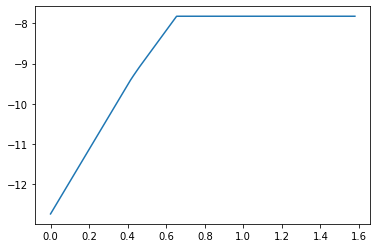

In [89]:
tlist = jnp.linspace(0,p_final[0],100)
Alist = vmap(A,(None,0,None),0)(omega0,tlist,p_final[1])
plt.plot(tlist,Alist)

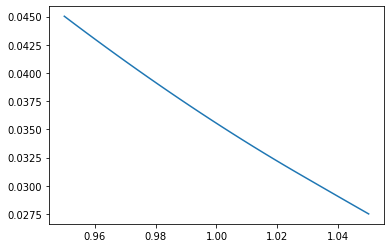

In [91]:
omegalist = jnp.linspace(omega0-0.05,omega0+0.05,30)
losslist = lossvmap(p_final[0],p_final[1],omegalist,sx)

plt.plot(omegalist,losslist)